In [1]:
%matplotlib nbagg
%load_ext line_profiler
%load_ext autoreload

In [2]:
import math
import json
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
import scipy.sparse
import sparse
import numba
import scipy.io as spio
from scipy.linalg import norm

In [3]:
from libertem import api
from libertem.executor.inline import InlineJobExecutor
from libertem.executor.base import AsyncAdapter
from libertem.common.backend import set_use_cuda, set_use_cpu, get_device_class
from libertem.udf.base import UDFRunner, UDF
from libertem.common.container import MaskContainer
from libertem.masks import circular
from libertem.corrections.coordinates import identity

In [4]:
from ptychography.reconstruction.ssb import SSB_UDF, generate_masks
from ptychography.reconstruction.common import wavelength, get_shifted

In [5]:
path = "/storage/holo/clausen/testdata/ER-C-1/projects/ptycho-4.0/data/RefData/slice_00002_thick_0.312293_nm_blocksz.mat"
param_path = "/storage/holo/clausen/testdata/ER-C-1/projects/ptycho-4.0/data/slice_00002_thick_0.312293_nm_blocksz.params.json"

imgstack = spio.loadmat(path, squeeze_me = True)
complex_diffract = imgstack['imgstack_cdp']
intensity = imgstack['imgstack_idp']

In [6]:
complex_diffract.shape

(262, 262, 1075)

In [7]:
with open(param_path) as f:
    rec_params = json.load(f)
rec_params

{'semiconv_pix': 16,
 'cy': 130,
 'cx': 135,
 'U': 80,
 'dpix': [1.0950026e-11, 1.2643999999999998e-11],
 'semiconv': 0.0115,
 'transformation': [[1.0, 0.0], [0.0, 1.0]],
 'shape': [43, 25, 262, 262]}

In [8]:
semiconv_pix = rec_params['semiconv_pix']
cy = rec_params['cy']
cx = rec_params['cx']
U = rec_params['U']
dpix = rec_params['dpix']
semiconv = rec_params['semiconv']
transformation = np.array(rec_params['transformation'])

<IPython.core.display.Javascript object>


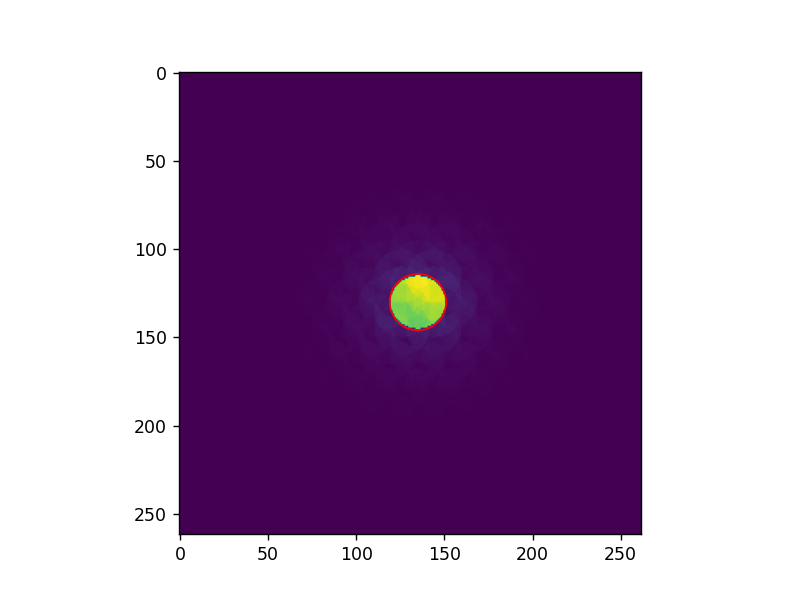

In [9]:
fig, axes = plt.subplots()
axes.imshow(np.abs(complex_diffract[:, :, 123]))
circ_a = plt.Circle((cx, cy), semiconv_pix, fill=False, color='red')
axes.add_artist(circ_a)

In [10]:
Nx = intensity.shape[1]
Ny = intensity.shape[0]

## Get the average
measure_amplitude_av = (np.sum(np.sum(np.sqrt(np.abs(intensity)), axis = 0), axis = 0)/(Nx*Ny) ).reshape(43,25)
grtruth_amplitude_av = (np.sum(np.sum(np.abs(complex_diffract), axis = 0), axis = 0)/(Nx*Ny)).reshape(43,25)
grtruth_phase_av = (np.sum(np.sum(np.angle(complex_diffract),axis = 0), axis = 0)/(Nx*Ny)).reshape(43,25)
norm(measure_amplitude_av - grtruth_amplitude_av)

5.367672863358296e-16

<IPython.core.display.Javascript object>


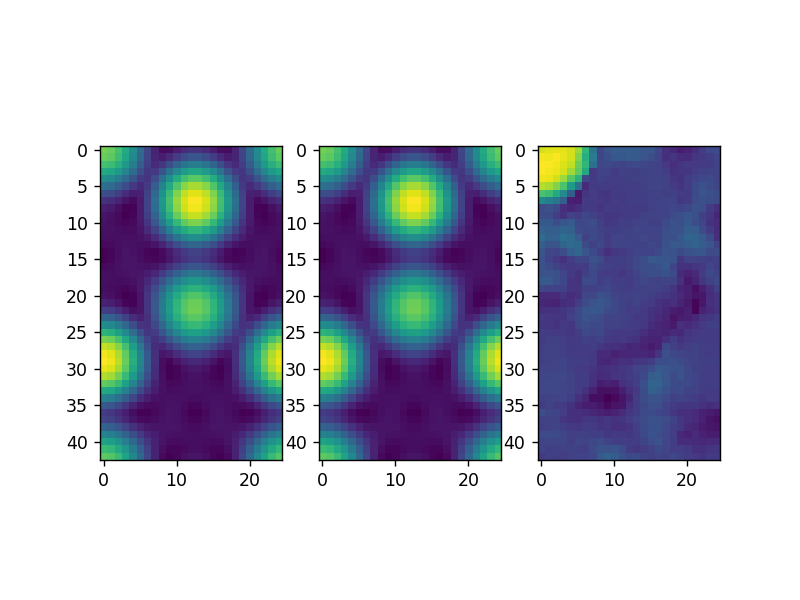

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(measure_amplitude_av)
ax2.imshow(grtruth_amplitude_av)
ax3.imshow(grtruth_phase_av)

In [12]:
plane_wave = complex_diffract[cy, cx].reshape(43, 25)

<IPython.core.display.Javascript object>


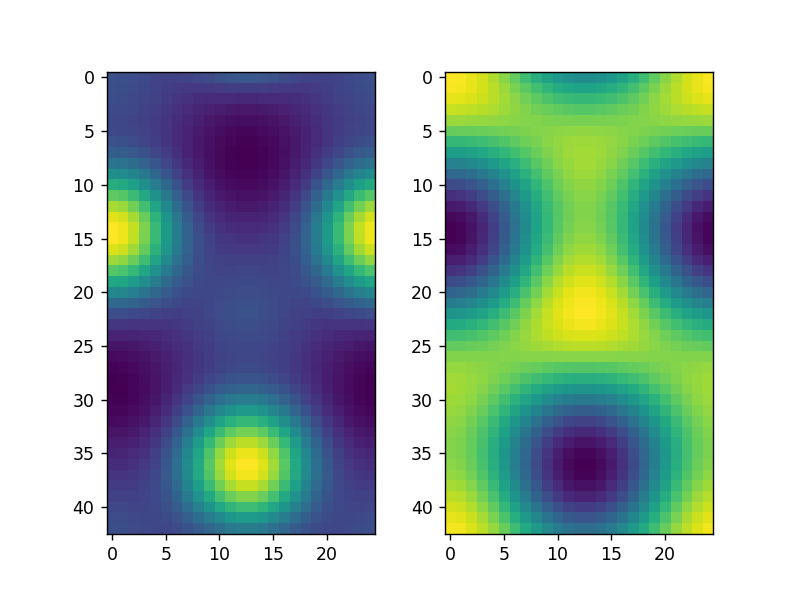

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(np.abs(plane_wave))
axes[1].imshow(np.angle(plane_wave))

In [14]:
executor = InlineJobExecutor()
ctx = api.Context(executor=executor)
# async_executor = AsyncAdapter(executor)
# ctx = api.Context()

In [15]:
# set_use_cuda(0)
# set_use_cpu(0)

In [16]:
# ctx.executor.client.scheduler_info()

In [17]:
pixelated_stem = np.moveaxis(imgstack['imgstack_idp'], (2,), (0,)).reshape((43, 25, 262, 262))

In [18]:
ds = ctx.load("memory", data=pixelated_stem, sig_dims=2)

In [19]:
a = ctx.create_com_analysis(dataset=ds, cy=cy, cx=cx, mask_radius=semiconv_pix+1)

In [20]:
res = ctx.run(a)

In [21]:
res.keys

<bound method AnalysisResultSet.keys of [<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: curl>, <AnalysisResult: x>, <AnalysisResult: y>]>

<IPython.core.display.Javascript object>


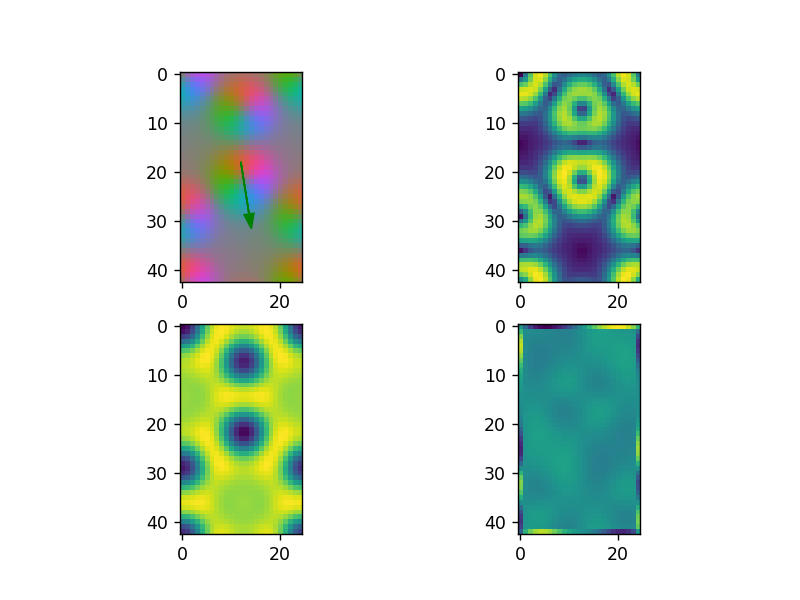

In [22]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(res.field.visualized)
axes[0, 0].arrow(12, 18, res.field.raw_data[0][18, 12]*10, res.field.raw_data[1][18, 12]*10, color='green', head_width=2)
axes[0, 1].imshow(res.magnitude.raw_data)
axes[1, 0].imshow(res.divergence.raw_data)
axes[1, 1].imshow(res.curl.raw_data)

In [23]:
print(np.abs(res.curl.raw_data[1:-1, 1:-1]).sum())
print(np.abs(res.divergence.raw_data[1:-1, 1:-1]).sum())
print(res.x.raw_data.sum(), res.y.raw_data.sum())
print(np.abs(res.x.raw_data).sum(), np.abs(res.y.raw_data).sum())

2.75898089980042
189.95716814824365
-4.774847184307873e-12 -2.0025630436021515
410.1098030705257 400.6735841858053


In [24]:
def reference_ssb(data, U, dpix, semiconv, semiconv_pix, cy=None, cx=None):

    # 'U' - The acceleration voltage U in keV
    # 'dpix' - STEM pixel size in m
    # 'semiconv' -  STEM semiconvergence angle in radians
    # 'semiconv_pix' - Diameter of the primary beam in the diffraction pattern in pixels

    dpix = np.array(dpix)
    
    reordered = np.moveaxis(data, (0, 1), (2, 3))
    ffts = np.fft.fft2(reordered)
    rearranged_ffts = np.moveaxis(ffts, (2, 3), (0, 1))

    Nblock = np.array(data.shape[0:2])
    Nscatter = np.array(data.shape[2:4])

    # electron wavelength in m
    lamb = wavelength(U)
    # spatial freq. step size in scattering space
    d_Kf = np.sin(semiconv)/lamb/semiconv_pix
    # spatial freq. step size according to probe raster
    d_Qp = 1/dpix/Nblock

    result_f = np.zeros(data.shape[:2], dtype=rearranged_ffts.dtype)

    masks = np.zeros_like(data)

    if cx is None:
        cx = data.shape[-1] / 2
    if cy is None:
        cy = data.shape[-2] / 2

    y, x = np.ogrid[0:Nscatter[0], 0:Nscatter[1]]
    filter_center = circular(
        centerX=cx, centerY=cy,
        imageSizeX=Nscatter[1], imageSizeY=Nscatter[0],
        radius=semiconv_pix,
        antialiased=True
    ).astype(np.float64)

    for row in range(Nblock[0]):
        for column in range(Nblock[1]):
            qp = np.array((row, column))
            flip = qp > Nblock / 2
            real_qp = qp.copy()
            real_qp[flip] = qp[flip] - Nblock[flip]

            sy, sx = real_qp * d_Qp / d_Kf

            filter_positive = circular(
                centerX=cx+sx, centerY=cy+sy,
                imageSizeX=Nscatter[1], imageSizeY=Nscatter[0],
                radius=semiconv_pix,
                antialiased=True
            ).astype(np.float64)

            filter_negative = circular(
                centerX=cx-sx, centerY=cy-sy,
                imageSizeX=Nscatter[1], imageSizeY=Nscatter[0],
                radius=semiconv_pix,
                antialiased=True
            ).astype(np.float64)
            mask_positive = filter_center * filter_positive * (filter_negative == 0)
            mask_negative = filter_center * filter_negative * (filter_positive == 0)

            non_zero_positive = mask_positive.sum()
            non_zero_negative = mask_negative.sum()

            f = rearranged_ffts[row, column]

            if non_zero_positive >= 1 and non_zero_negative >= 1:
                tmp = ((f * mask_positive).sum() / non_zero_positive - (f * mask_negative).sum() / non_zero_negative) / 2
                result_f[row, column] = tmp
                masks[row, column] = ((mask_positive / non_zero_positive) - (
                               mask_negative / non_zero_negative)) / 2
                assert np.allclose(result_f[row, column], (f*masks[row, column]).sum())
            else:
                assert non_zero_positive < 1
                assert non_zero_negative < 1

    result_f[0, 0] = (rearranged_ffts[0, 0] * filter_center).sum() / filter_center.sum()
    masks[0, 0] = filter_center / filter_center.sum()

    return result_f, masks

In [25]:
dtype = np.float64
shape = ds.shape
reconstruct_shape = ds.shape[:2]

In [26]:
%%time
result_f, reference_masks = reference_ssb(pixelated_stem, U, dpix, semiconv, semiconv_pix, cy, cx)

CPU times: user 24.9 s, sys: 2.05 s, total: 26.9 s
Wall time: 26.9 s


In [27]:
%%time
%autoreload

masks = generate_masks(
    reconstruct_shape=reconstruct_shape,
    mask_shape=shape[2:],
    dtype=dtype,
    lamb=wavelength(U),
    dpix=dpix,
    semiconv=semiconv,
    semiconv_pix=semiconv_pix,
    center=(cy, cx),
    transformation=transformation,
    cutoff=1,
    method='subpix'
)

if get_device_class() == 'cuda':
    backend = 'cupy'
else:
    backend = 'numpy'

mask_container = MaskContainer(
    mask_factories=lambda: masks, dtype=masks.dtype,
    use_sparse='scipy.sparse.csc', count=masks.shape[0], backend=backend,
)

CPU times: user 342 ms, sys: 18.5 ms, total: 360 ms
Wall time: 360 ms


In [28]:
%%time
%autoreload

masks_shift = generate_masks(
    reconstruct_shape=reconstruct_shape,
    mask_shape=shape[2:],
    dtype=dtype,
    lamb=wavelength(U),
    dpix=dpix,
    semiconv=semiconv,
    semiconv_pix=semiconv_pix,
    center=(cy, cx),
    transformation=transformation,
    cutoff=1,
    method='shift'
)

if get_device_class() == 'cuda':
    backend = 'cupy'
else:
    backend = 'numpy'

mask_container_shift = MaskContainer(
    mask_factories=lambda: masks_shift, dtype=masks_shift.dtype,
    use_sparse='scipy.sparse.csc', count=masks_shift.shape[0], backend=backend,
)

CPU times: user 7.02 s, sys: 26.4 ms, total: 7.05 s
Wall time: 7.05 s


<IPython.core.display.Javascript object>


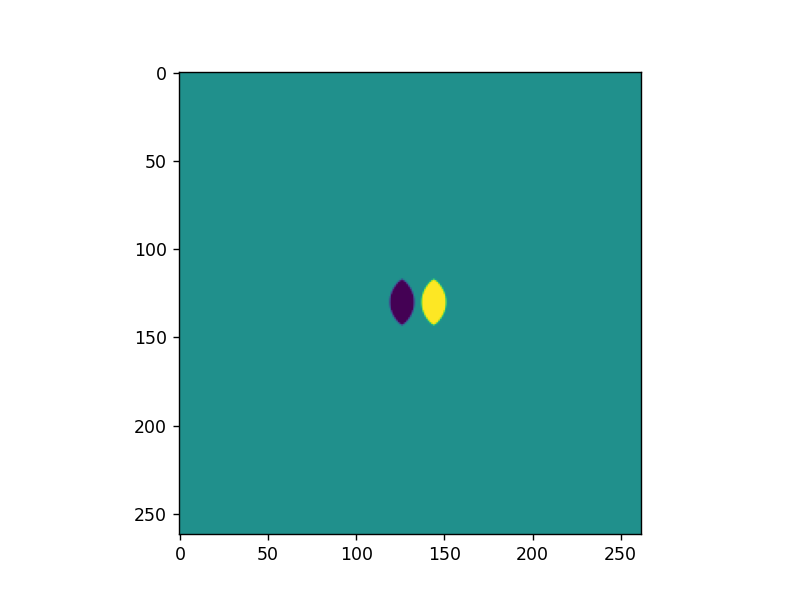

In [29]:
fig, axes = plt.subplots()
axes.imshow(masks_shift[1].todense())

In [30]:
%autoreload
udf = SSB_UDF(
    U=U, dpix=dpix, semiconv=semiconv, semiconv_pix=semiconv_pix,
    dtype=dtype, center=(cy, cx), transformation=transformation,
    mask_container=mask_container, cutoff=1,
)

In [31]:
%%time
udf_result = ctx.run_udf(udf=udf, dataset=ds)

CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 2.17 s


In [32]:
%autoreload
udf_shift = SSB_UDF(
    U=U, dpix=dpix, semiconv=semiconv, semiconv_pix=semiconv_pix,
    dtype=dtype, center=(cy, cx), transformation=transformation,
    mask_container=mask_container_shift, cutoff=1
)

In [33]:
%%time
udf_result_shift = ctx.run_udf(udf=udf_shift, dataset=ds)

CPU times: user 2.63 s, sys: 2.62 ms, total: 2.63 s
Wall time: 2.63 s


<IPython.core.display.Javascript object>


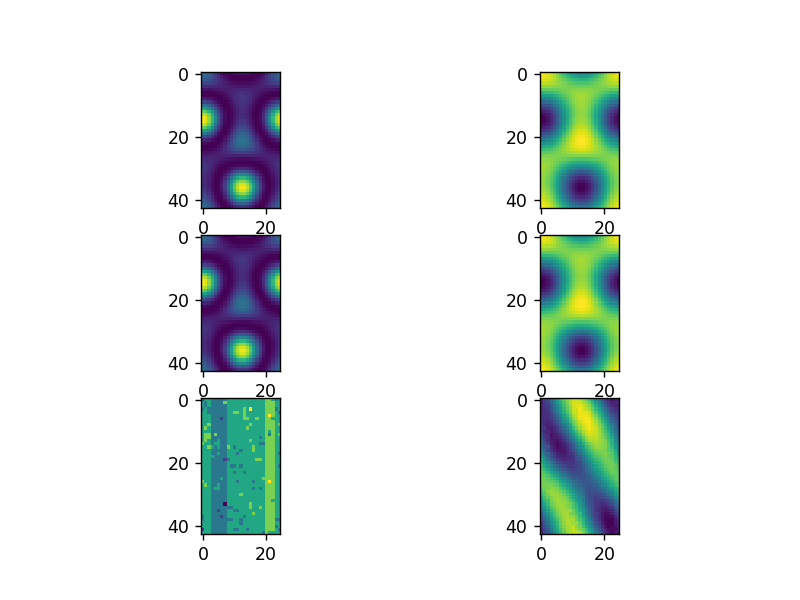

In [34]:
fig, axes = plt.subplots(3, 2)
ref_rec = np.fft.ifft2(result_f)
udf_rec = np.fft.ifft2(udf_result["pixels"].data)

axes[0, 0].imshow(np.abs(ref_rec))
axes[0, 1].imshow(np.angle(ref_rec))
axes[1, 0].imshow(np.abs(udf_rec))
axes[1, 1].imshow(np.angle(udf_rec))
axes[2, 0].imshow(np.abs(udf_rec) - np.abs(ref_rec))
axes[2, 1].imshow(np.angle(udf_rec) - np.angle(ref_rec))

<IPython.core.display.Javascript object>


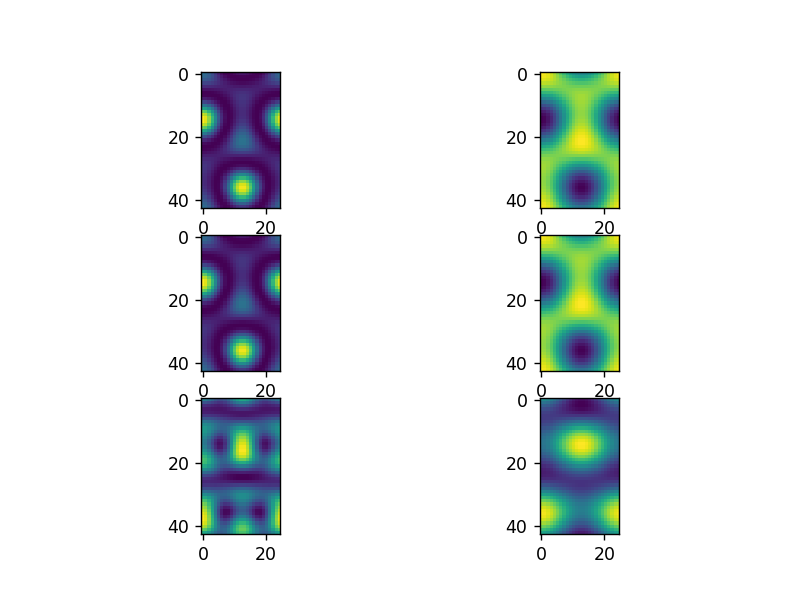

In [35]:
fig, axes = plt.subplots(3, 2)
ref_rec = np.fft.ifft2(result_f)
udf_shift_rec = np.fft.ifft2(udf_result_shift["pixels"].data)

axes[0, 0].imshow(np.abs(ref_rec))
axes[0, 1].imshow(np.angle(ref_rec))
axes[1, 0].imshow(np.abs(udf_shift_rec))
axes[1, 1].imshow(np.angle(udf_shift_rec))
axes[2, 0].imshow(np.abs(udf_shift_rec) - np.abs(ref_rec))
axes[2, 1].imshow(np.angle(udf_shift_rec) - np.angle(ref_rec))

In [36]:
np.allclose(udf_result_shift["pixels"], udf_result["pixels"])

False

In [37]:
np.std(udf_shift_rec - udf_rec), np.std(udf_rec)

(0.15130513078584973, 20.51157220497409)

<IPython.core.display.Javascript object>


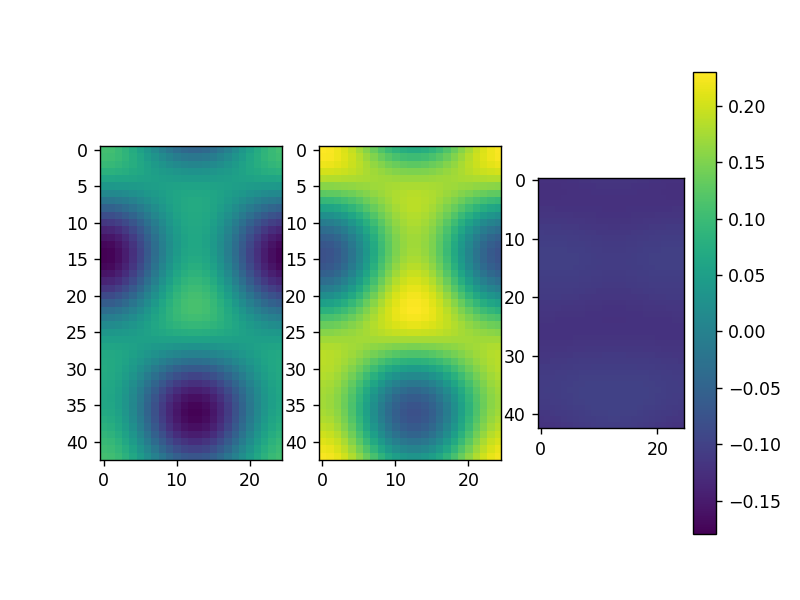

In [38]:
fig, axes = plt.subplots(1, 3)

rec = np.fft.ifft2(udf_result_shift["pixels"].data)

ssb_phase = np.angle(rec)
ctem_phase = np.angle(plane_wave)

ssb_amp = np.abs(rec)
ctem_amp = np.abs(plane_wave)

vmin_phase = np.min((ssb_phase, ctem_phase))
vmax_phase = np.max((ssb_phase, ctem_phase))
axes[0].imshow(ssb_phase, vmin=vmin_phase, vmax=vmax_phase)
axes[1].imshow(ctem_phase, vmin=vmin_phase, vmax=vmax_phase)
p = axes[2].imshow(ssb_phase - ctem_phase, vmin=vmin_phase, vmax=vmax_phase)
plt.colorbar(p)

# vmin_amp = np.min((ssb_amp, ctem_amp))
# vmax_amp = np.max((ssb_amp, ctem_amp))
# axes[1, 0].imshow(ssb_amp, vmin=vmin_amp, vmax=vmax_amp)
# axes[1, 1].imshow(ctem_amp, vmin=vmin_amp, vmax=vmax_amp)
# p = axes[1, 2].imshow(ssb_amp - ctem_amp, vmin=vmin_amp, vmax=vmax_amp)
# plt.colorbar(p)

In [39]:
np.std(ssb_phase), np.std(ctem_phase), np.std(ssb_phase - ctem_phase)

(0.07438195637907281, 0.07950959445102392, 0.006784609902090541)